# Home Credit Gradient Boosted Trees Model 

### By Rachel Butterfield 7/22/23 

## Introduction

Project Goal: Home Credit will be able to identify if a customer is a safe candidate to lend to, then create a personalized customer loan and repayment plan to be accountable for, resulting in an increase in revenue, improved customer experience, and lower default rates.

Business Problem: Home Credit desires to know safe borrowers in a customer base that is unfamiliar with banking and give the customer a plan for successful loan repayment. Lending to those who are more likely to default on loans decreases the profits of Home Credit and results in negative customer experiences.

Analytic Problem:

The target variable is specificially customers that do have a negative history of repayment to lend to, and postive repayment. Represented in the application_train/test.csv sets of binary where 1 = Not trust worthy borrower (Client with payment difficulties), 0 = Trustworthy borrower (client with good repayment history).

   -Predict which customers will be good borrowers, using a classification method based on customer financial behavior data.

   -Use a machine learning method to see the relationship that a trust worthy customer has to other attributes about them.

### Machine Learning Model Choice - XGBoost (Gradient Boosted Trees) 

A gradient boosted tree method, such as XGBoost, can be a good approach for predicting loan defaults due to several reasons:

-it effectively models non-linear relationships 

-it handles large datasets with a large number of features and observations 

-it is designed to be computationally efficient, allowing for faster training and prediction on large datasets

-it is less sensitive to outliers compared to some other machine learning algorithms 

-it can handle imbalanced datasets effectively by using oversampling

-it provides a way to assess the importance of features in the prediction process

## Importing packages and data

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import warnings

During the process of editing the model and testing it, I found that I needed to pull in only certain fields from certain datasets. Merging all of the data was not a feasible computing option for my current set up (although I did try it intially).  

In [2]:
#Load the necessary datasets
train_data = pd.read_csv('application_train.csv')
test_data = pd.read_csv('application_test.csv')
pos_cash_balance = pd.read_csv('POS_CASH_balance.csv')
bureau = pd.read_csv('bureau.csv')
#bureau_balance = pd.read_csv('bureau_balance.csv')
credit_card_balance = pd.read_csv('credit_card_balance.csv')
#installments_payments = pd.read_csv('installments_payments.csv')
#previous_application = pd.read_csv('previous_application.csv')

In [3]:
#Shape of datasets
print(train_data.shape)
print(test_data.shape)
print(pos_cash_balance.shape)
print(bureau.shape)
#print(bureau_balance.shape)
print(credit_card_balance.shape)
#print(installments_payments.shape)
#print(previous_application.shape)

(307511, 122)
(48744, 121)
(10001358, 8)
(1716428, 17)
(3840312, 23)


## Joining in Datasets 

While attending one of the class webinars, Jeremy Morris suggested that I consider pulling in some of the averages of the fields that could be correlated with the target variable. I thought the count of days since overdue payments on both credit card balance and the bureau tables would be good to examine.

In [4]:
#Calculate average 'SK_DPD' values in credit_card_balance.csv
average_sk_dpd = credit_card_balance.groupby('SK_ID_CURR')['SK_DPD'].mean().reset_index()

#Merge average_sk_dpd with train_data based on 'SK_ID_CURR'
train_data = train_data.merge(average_sk_dpd, on='SK_ID_CURR', how='left')

#Merge average_sk_dpd with test_data based on 'SK_ID_CURR'
test_data = test_data.merge(average_sk_dpd, on='SK_ID_CURR', how='left')

#Fill missing values with 0
train_data['SK_DPD'] = train_data['SK_DPD'].fillna(0)
test_data['SK_DPD'] = test_data['SK_DPD'].fillna(0)

In [5]:
#Calculate average 'CREDIT_DAY_OVERDUE' values in bureau.csv
average_credit_day_overdue = bureau.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].mean().reset_index()

#Merge average_credit_day_overdue with train_data based on 'SK_ID_CURR'
train_data = train_data.merge(average_credit_day_overdue, on='SK_ID_CURR', how='left')

#Merge average_credit_day_overdue with test_data based on 'SK_ID_CURR'
test_data = test_data.merge(average_credit_day_overdue, on='SK_ID_CURR', how='left')

#Fill missing values with 0
train_data['CREDIT_DAY_OVERDUE'] = train_data['CREDIT_DAY_OVERDUE'].fillna(0)
test_data['CREDIT_DAY_OVERDUE'] = test_data['CREDIT_DAY_OVERDUE'].fillna(0)

In [6]:
#Shape of the joined datasets
print(train_data.shape)
print(test_data.shape)

(307511, 124)
(48744, 123)


In [7]:
#First 10 rows on the joined dataset
train_data.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_DPD,CREDIT_DAY_OVERDUE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


## EDA Continued

The majority of the EDA examination and visuals were completed in the EDA portion of this project that was previously turned in. I did implement some of the strategies that we suggested in that assignment. I dropped any column that was missing more than 30% of it's values and imputed the mean value for columns with less than 30% null values. 

### Missing Data

In [8]:
#Calculate the null count and percentage for all columns
null_counts = train_data.isnull().sum()
null_percentages = (null_counts / len(train_data)) * 100

#Create a DataFrame to display the results
null_info = pd.DataFrame({
    'Column': null_counts.index,
    'Null Count': null_counts,
    'Null Percentage': null_percentages
})

#Sort the DataFrame by null percentages in descending order
null_info_sorted = null_info.sort_values('Null Percentage', ascending=False)

#Print the columns with null values and their percentages
print("Columns with null values (sorted by null percentages):")
print(null_info_sorted.to_string(formatters={'Null Percentage': '{:.2f}%'.format}, index=False))

Columns with null values (sorted by null percentages):
                      Column  Null Count Null Percentage
             COMMONAREA_MODE      214865          69.87%
              COMMONAREA_AVG      214865          69.87%
             COMMONAREA_MEDI      214865          69.87%
    NONLIVINGAPARTMENTS_MEDI      213514          69.43%
     NONLIVINGAPARTMENTS_AVG      213514          69.43%
    NONLIVINGAPARTMENTS_MODE      213514          69.43%
          FONDKAPREMONT_MODE      210295          68.39%
       LIVINGAPARTMENTS_MEDI      210199          68.35%
        LIVINGAPARTMENTS_AVG      210199          68.35%
       LIVINGAPARTMENTS_MODE      210199          68.35%
              FLOORSMIN_MEDI      208642          67.85%
               FLOORSMIN_AVG      208642          67.85%
              FLOORSMIN_MODE      208642          67.85%
             YEARS_BUILD_AVG      204488          66.50%
            YEARS_BUILD_MODE      204488          66.50%
            YEARS_BUILD_MEDI     

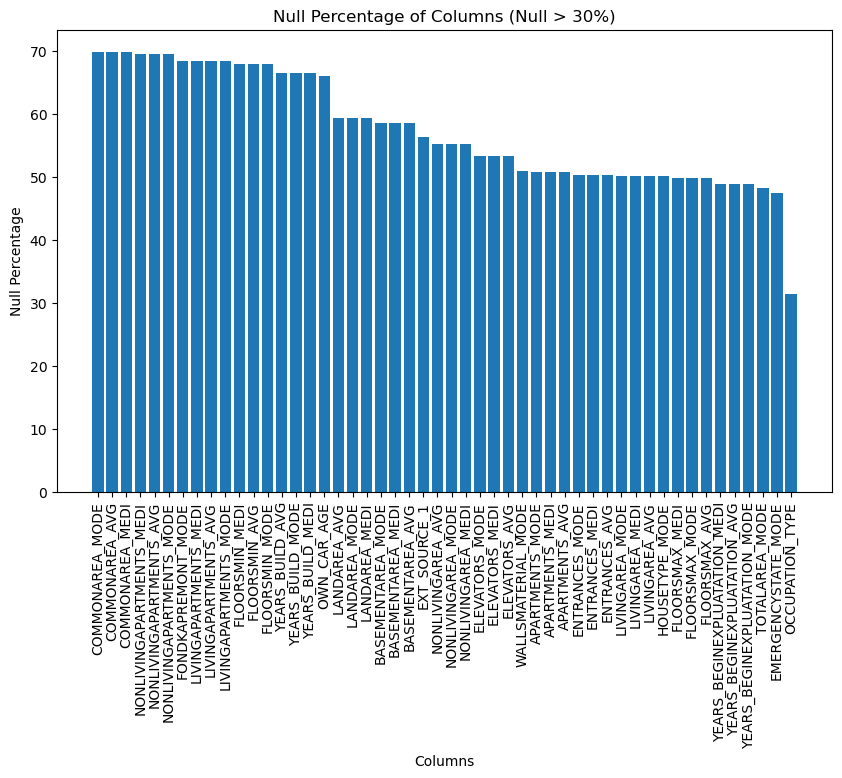

In [9]:
#Plotting the null values

#Filter the DataFrame for columns with null percentages greater than 30%
filtered_null_info = null_info_sorted[null_info_sorted['Null Percentage'] > 30]

# Set the figure size
plt.figure(figsize=(10, 6))

#Create the bar plot
plt.bar(filtered_null_info['Column'], filtered_null_info['Null Percentage'])
plt.xticks(rotation='vertical')
plt.xlabel('Columns')
plt.ylabel('Null Percentage')
plt.title('Null Percentage of Columns (Null > 30%)')

#Show the plot
plt.show()

In [10]:
#Remove columns with more than 30% null values
train_data = train_data.dropna(thresh=len(train_data) * 0.7, axis=1)
test_data = test_data.dropna(thresh=len(test_data) * 0.7, axis=1)

#Select valid numeric columns
numeric_columns = train_data.select_dtypes(include=np.number).columns

#Impute mean for numeric columns with less than 30% null values in train_data
train_data = train_data.loc[:, numeric_columns].fillna(train_data.loc[:, numeric_columns].mean())

#Select valid numeric columns in test
test_numeric_columns = test_data.select_dtypes(include=np.number).columns

#Impute mean for numeric columns with less than 30% null values in test_data
test_data = test_data.loc[:, test_numeric_columns].fillna(test_data.loc[:, test_numeric_columns].mean())

In [11]:
# Check for null values in train_data
null_counts = train_data.isnull().sum()

print(null_counts)

print(train_data.shape)
print(test_data.shape)

SK_ID_CURR                    0
TARGET                        0
CNT_CHILDREN                  0
AMT_INCOME_TOTAL              0
AMT_CREDIT                    0
                             ..
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
SK_DPD                        0
CREDIT_DAY_OVERDUE            0
Length: 63, dtype: int64
(307511, 63)
(48744, 62)


Reviewing the columns with more than 30% null values dropped the number of variables in the train and test sets by 61. 

### Encoding Categorical Variables

I used the onehotencorder function to change all the object variables into categorical variables, so the model would be able to evaluate them. 

In [14]:
# Encode categorical variables in train data
categorical_cols = train_data.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(handle_unknown='ignore')

encoded_cols = pd.DataFrame(encoder.fit_transform(train_data[categorical_cols]).toarray())
train_data = pd.concat([train_data, encoded_cols], axis=1).drop(categorical_cols, axis=1)

# Encode categorical variables in test data
encoded_cols = pd.DataFrame(encoder.transform(test_data[categorical_cols]).toarray())
test_data = pd.concat([test_data, encoded_cols], axis=1).drop(categorical_cols, axis=1)

### Scale and Normalized Numeric Features

I thought scaling and normalizing the numeric features would help the model, but it ended up having a negative impact. I believe this is the case because many of the numeric variables on the train and test set had already been normalized. 

In [15]:
# Exclude 'SK_ID_CURR' and 'TARGET' from the numerical columns
#numerical_cols = train_data.select_dtypes(include=['float', 'int']).columns
#numerical_cols = numerical_cols.drop(['SK_ID_CURR', 'TARGET'])

# Scale/Normalize numerical features in train data
#scaler = StandardScaler()
#train_data[numerical_cols] = scaler.fit_transform(train_data[numerical_cols].values)

# Exclude 'SK_ID_CURR' from the numerical columns
#test_numerical_cols = test_data.select_dtypes(include=['float', 'int']).columns
#test_numerical_cols = test_numerical_cols.drop('SK_ID_CURR')

# Scale/Normalize numerical features in test data
#scaler = StandardScaler()
#test_data[test_numerical_cols] = scaler.fit_transform(test_data[test_numerical_cols].values)

## Modeling Process

### Oversampling on the Training Set 

Since the target variable values are so heavy skewed for those who do not default on a loan (Target = 0), I split the training set into its own train, test, and validation and performed an oversampling on the split datasets. 

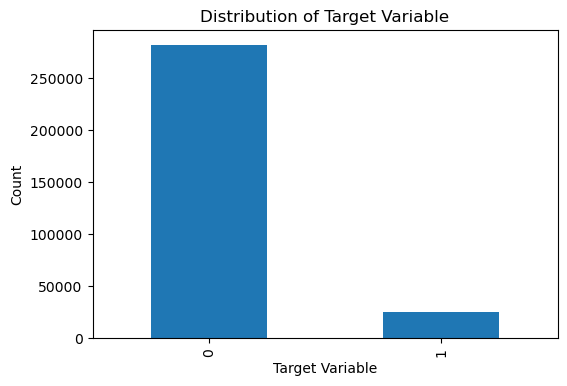

In [16]:
#Value counts of the target variable
target_counts = train_data['TARGET'].value_counts()

#Set the figure size
plt.figure(figsize=(6, 4))

#Create the bar plot
target_counts.plot(kind='bar')

#Set the labels and title
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.title('Distribution of Target Variable')

#Show the plot
plt.show()

In [17]:
#Split the data into training and validation sets
y = train_data['TARGET']
X = train_data.drop('TARGET', axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#Perform oversampling on the training set
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

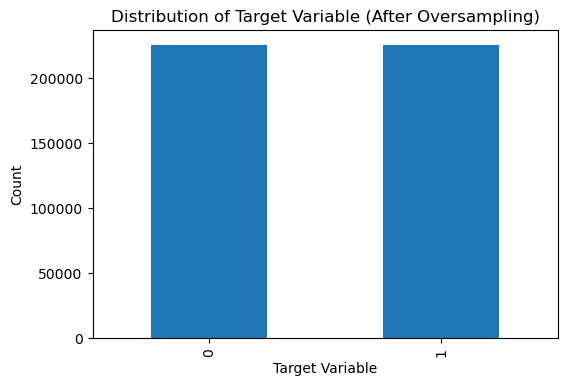

In [18]:
#Calculate the count of each class in the resampled training set
target_counts_resampled = pd.Series(y_train_resampled).value_counts()

#Set the figure size
plt.figure(figsize=(6, 4))

#Create the bar plot
target_counts_resampled.plot(kind='bar')

#Set the labels and title
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.title('Distribution of Target Variable (After Oversampling)')

#Show the plot
plt.show()

You can see by the distribution of the target variable after oversampling that it is a lot more balanced than before running the oversampling.

### Hyperparameter Tuning

When picking a search option for the boosted trees model, I first went with a grid search. My computer was having a difficult time processing it for such a large dataset, so I searched for what might work better. I found a suggestion to use a randomized search instead and it was helpful in reducing the processing time while still ensuring a semi-accurate model. 

In [19]:
#Create an XGBoost classifier
xgb_model = xgb.XGBClassifier()

#Define the parameter distributions for randomized search
param_dist = {
    'n_estimators': randint(100, 500),       
    'max_depth': randint(3, 10),             
    'learning_rate': uniform(0.01, 0.1)    
}

#Perform randomized search for hyperparameter tuning with increased iterations and cv folds
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=5, cv=2, scoring='accuracy')
random_search.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           predictor=None, random_state=None, ...),
           

### Training the Model and Cross Validation

In [20]:
#Get the best estimator from randomized search
best_xgb_model = random_search.best_estimator_

I performed a x5 cross validation method to test the accuracy of the model. The results of that is below in the accuracy of the model section.

In [21]:
#Evaluate the model using cross-validation
cv_scores = cross_val_score(best_xgb_model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')

In [22]:
#Make predictions on the validation set
val_predictions = best_xgb_model.predict(X_val)

### Feature Importance 

I ran this model many times trying to change it increase the accuracy. Each time the top feature importance fields would change slighly depending on the perimeters of the model. The top 5 important features of this final version include EXT_SOURCE_3, EXT_SOURCE_2, AMT_REQ_CREDIT_BUREAU_DAY, FLAG_DOCUMENT_3 and, FLAG_DOCUMENT_16.

In [23]:
#Feature importance
feature_importances = best_xgb_model.feature_importances_

#Create a DataFrame to store the feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

#Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values('Importance', ascending=False)

#Display the top 10 most important features
print("Top 10 most important features:")
#Use f-string to limit the importance values to 4 decimal places
print(importance_df.head(10).to_string(formatters={'Importance': '{:.4f}'.format}, index=False))

Top 10 most important features:
                    Feature Importance
               EXT_SOURCE_3     0.0623
               EXT_SOURCE_2     0.0448
  AMT_REQ_CREDIT_BUREAU_DAY     0.0399
            FLAG_DOCUMENT_3     0.0291
           FLAG_DOCUMENT_16     0.0256
            AMT_GOODS_PRICE     0.0246
REGION_RATING_CLIENT_W_CITY     0.0240
           FLAG_DOCUMENT_13     0.0215
   DEF_60_CNT_SOCIAL_CIRCLE     0.0213
     REG_CITY_NOT_LIVE_CITY     0.0207


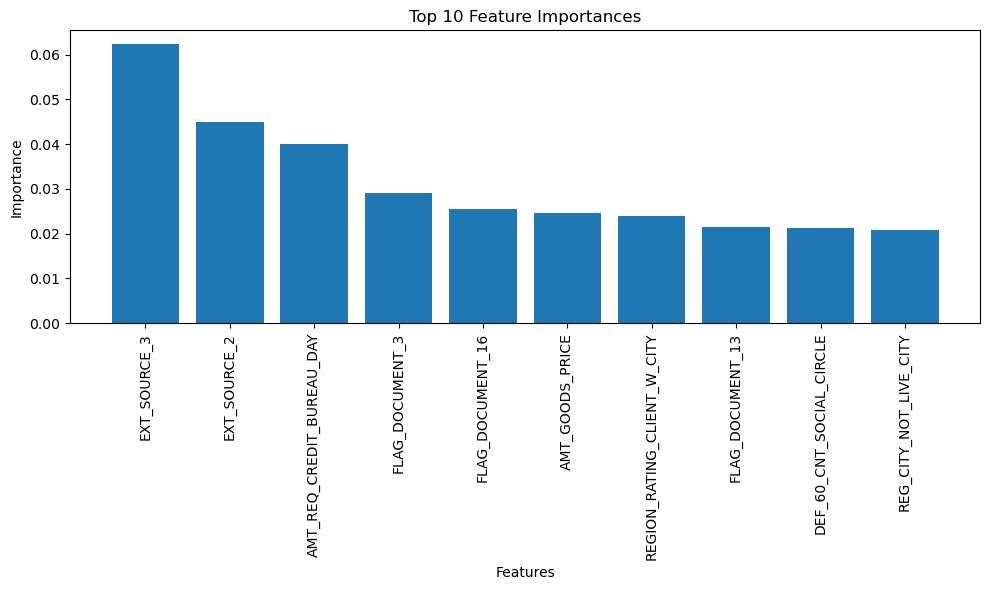

In [45]:
#Visualize the top 20 feature importance

#Set the figure size
plt.figure(figsize=(10, 6))

#Select the top 10 most important features
top_10_importance = importance_df.head(10)

#Create the bar plot for the top 10 features
plt.bar(top_10_importance['Feature'], top_10_importance['Importance'])
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances')

#Adjust the spacing between the bars and the plot's edges
plt.tight_layout()

#Display the plot
plt.show()

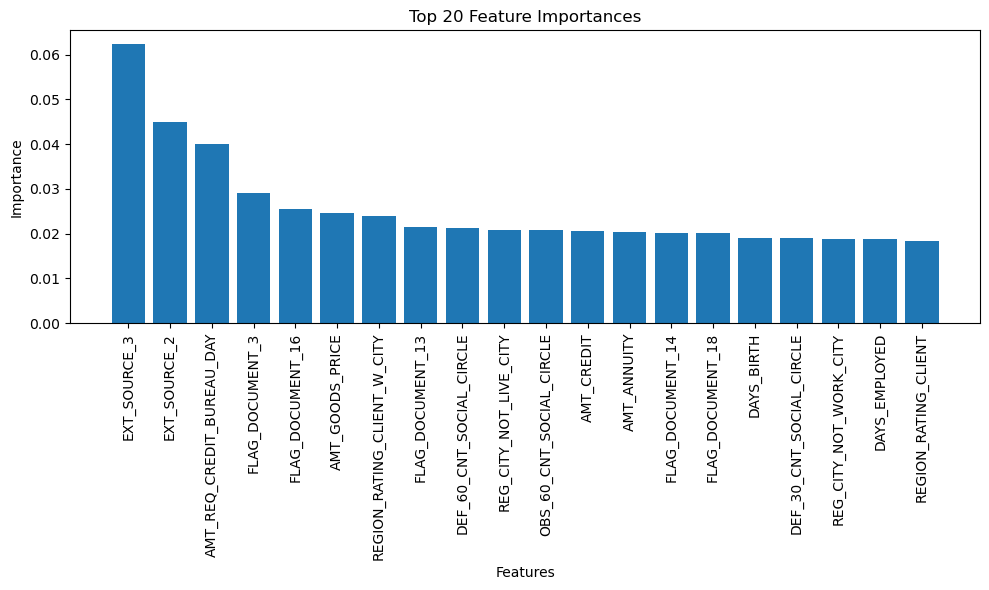

In [34]:
#Visualize the top 20 feature importance

#Set the figure size
plt.figure(figsize=(10, 6))

#Select the top 10 most important features
top_20_importance = importance_df.head(20)

#Create the bar plot for the top 10 features
plt.bar(top_20_importance['Feature'], top_20_importance['Importance'])
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 20 Feature Importances')

#Adjust the spacing between the bars and the plot's edges
plt.tight_layout()

#Display the plot
plt.show()

### Accuracy of the Model 

In [27]:
#Calculate the AUC score
auc_score = roc_auc_score(y_val, val_predictions)

#Print the AUC score 
print("AUC Score: {:.4f}".format(auc_score))


AUC Score: 0.6617


This model received a AUC score fo .6617 suggesting that this model has a fair level of predictive power.

In [28]:
#Print the cross-validation scores
print("Cross-validation scores:", [round(score, 4) for score in cv_scores])

# Calculate the mean accuracy
mean_accuracy = np.mean(cv_scores)

# Print the mean accuracy 
print("Mean Accuracy:", round(mean_accuracy, 4))

Cross-validation scores: [0.8171, 0.817, 0.8238, 0.8175, 0.8206]
Mean Accuracy: 0.8192


The mean accuracy from the cross validation process is .8192, which I was happy about. In early versions of this model I was getting scores of .90+ and I knew the model was overfitting to training set. I believe these accuracy scores to be more in line with reality.

In [29]:
#Create confusion matrix
confusion_mat = confusion_matrix(y_val, val_predictions)
print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[44300 12254]
 [ 2276  2673]]


In [30]:
#Evaluating confusion matrix values
TN, FP, FN, TP = confusion_mat.ravel()

#Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

#Calculate precision
precision = TP / (TP + FP)

#Calculate recall
recall = TP / (TP + FN)

#Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

#Print the metrics 
print("Accuracy:", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1-score:", round(f1_score, 4))

Accuracy: 0.7638
Precision: 0.1791
Recall: 0.5401
F1-score: 0.269


The accuracy score is 0.7638, indicating that 76.38% of the predictions made by the model were correct. A precision score of 0.1791 indicates that out of all the cases predicted as positive, only 17.91% were actually true positives. A recall score of 0.5401 means that the model identified 54.01% of the actual positive cases.The F1-score is 0.269, which suggests that the model's overall performance is on the lower side.

### Prediction on the Test Set

In [31]:
#Make predictions on the test set
test_predictions = best_xgb_model.predict(test_data)

In [32]:
#Create a submission DataFrame
submission = pd.DataFrame({
    "SK_ID_CURR": test_data["SK_ID_CURR"], 
    "TARGET": test_predictions
})

#Remove duplicate SK_ID_CURR values
submission = submission.drop_duplicates(subset="SK_ID_CURR", keep="first")

#Save the submission DataFrame to a CSV file
submission.to_csv("submission.csv", index=False)

## Conclusion

In conclusion, the modeling process has yielded a satisfactory performance for predicting loan defaults using the gradient boosted tree approach. The model demonstrated good predictive power. It has provided valuable insights into the factors influencing loan defaults and has the potential to assist lenders in making informed decisions.

It is also important to acknowledge that there is always room for improvement. This model resulted in a Kaggle public score of .65604, which I was pleased with. The EDA and modeling process is time consuming. The top groups who obtained a score of ~.80 submitted their model hundreds of times and performed some impressive techniques to get it there. Despite the satisfactory performance, there are areas where further enhancements could be explored including feature eningeering and additional hyperparameter testing while running the model on a more robust machine that could handle it.